In [1]:
import os
import sys
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['CUDA_HOME'] = '/u/local/cuda/12.3'
# os.environ['PATH'] = f"/u/local/cuda/12.3/bin:{os.environ['PATH']}"
from IPython.display import display, HTML
# adjust width % as desired
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# clean unused memory
import gc
import psutil
gc.collect()
psutil.virtual_memory()

svmem(total=540801236992, available=532280631296, percent=1.6, used=7429279744, free=136263327744, active=180184338432, inactive=215473266688, buffers=269037568, cached=396839591936, shared=1372160, slab=2995601408)

In [ ]:
# import os
# from datetime import datetime
# # import pydot
# # import graphviz
# # import pipdeptree

# # !pipdeptree
# # !pip freeze > requirements.txt
# # Step 1: Create the requirements directory and filenames
# # os.makedirs("requirements", exist_ok=True)
# current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
# filename_basic = f"requirements_{current_time}.txt"
# filename_detailed = f"requirements-detailed_{current_time}.txt"
# filename_svg = f"dependencies_{current_time}.svg"
# filepath_basic = os.path.join("requirements", filename_basic)
# filepath_detailed = os.path.join("requirements", filename_detailed)
# filepath_svg = os.path.join("requirements", filename_svg)

# # Step 2: Run the commands and save the output to files without printing to the cell
# !pipdeptree 2>/dev/null | grep -E '^\w+' > {filepath_basic} 2>/dev/null
# !pipdeptree --freeze > {filepath_detailed} 2> /dev/null
# !pipdeptree --graph-output dot 2> /dev/null | dot -Tsvg -o {filepath_svg} 2> /dev/null

In [26]:
import inspect
import shutil
import json
import cupy as cp
import anndata as ad
import pyarrow.feather as fth
import torch
import pickle
import pandas as pd
import pyaging as pya
from pygam import LinearGAM, LogisticGAM, s
import numpy as np
import scipy
import scipy.sparse as sp
from scipy import stats, sparse
import seaborn as sns
import matplotlib.pyplot as plt
from numba import jit, prange
import matplotlib.gridspec as gridspec
from mepylome import Manifest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.stats.anova import anova_lm
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import KNNImputer, IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from patsy import dmatrix
from scipy.stats import pearsonr

In [4]:
h5ad_file_path_final = '/u/scratch/c/cobeaman/adata_final.h5ad'
adata_final = ad.read_h5ad(h5ad_file_path_final)

# Create a backup of the original AnnData object
# adata_backup = adata_final.copy()

In [31]:
print(adata_final)
print(adata_final.obs)

AnnData object with n_obs × n_vars = 2442 × 731787
    obs: 'Female', 'Age', 'Diagnosis'
    var: 'percent_na'
    layers: 'X_original'
             Female   Age   Diagnosis
SampleID                             
431-BG00001     1.0  51.0    BipolarI
431-BG00002     1.0  33.0    BipolarI
431-BG00003     0.0  49.0    BipolarI
431-BG00004     0.0  41.0    BipolarI
431-BG00006     0.0  64.0    BipolarI
...             ...   ...         ...
431-BG01563     0.0  50.0   Bipolar I
431-BG01444     1.0  37.0     Bipolar
431-BG01403     1.0  44.0     Bipolar
431-BG01413     1.0  33.9  Bipolar II
431-BG01378     1.0  57.0  Bipolar II

[2442 rows x 3 columns]


In [32]:
def predict_grimage2_components(adata, dir="pyaging_data", batch_size=1024):
    """
    Wrapper function to predict GrimAge2 and its components, including AgeAccelGrim2.
    Returns a new AnnData object with original data and GrimAge2 results.
    """
    if not isinstance(adata, ad.AnnData):
        raise TypeError("Input must be an AnnData object")

    # Create a copy of the original adata object
    adata_copy = adata.copy()

    # Run the original predict_age function
    pya.pred.predict_age(adata_copy, clock_names="grimage2", dir=dir, batch_size=batch_size)
    
    if "grimage2" not in adata_copy.obs:
        raise KeyError("'grimage2' not found in adata_copy.obs. Make sure predict_age() ran successfully.")
    
    # Load the GrimAge2 model
    model = pya.predict._pred_utils.load_clock("grimage2", "cuda" if torch.cuda.is_available() else "cpu", dir, pya.logger.Logger())
    
    # Get the input data
    X = adata_copy.obsm["X_grimage2"] if "X_grimage2" in adata_copy.obsm else adata_copy.X
    
    # Predict components
    components = predict_components(model, X, batch_size)
    
    # Add component predictions to adata_copy.obs
    for component, values in components.items():
        adata_copy.obs[f"grimage2_{component}"] = values
    
    # Rename components to match R code
    rename_dict = {
        'grimage2_ADM': 'DNAmADM',
        'grimage2_CystatinC': 'DNAmCystatinC',
        'grimage2_GDF15': 'DNAmGDF15',
        'grimage2_Leptin': 'DNAmLeptin',
        'grimage2_PAI1': 'DNAmPAI1',
        'grimage2_TIMP1': 'DNAmTIMP1',
        'grimage2_LogCRP': 'DNAmlogCRP',
        'grimage2_A1C': 'DNAmlogA1C',
        'grimage2_PACKYRS': 'DNAmPACKYRS',
        'grimage2_B2M': 'DNAmB2M'
    }
    adata_copy.obs.rename(columns=rename_dict, inplace=True)
    
    # Calculate AgeAccelGrim2
    adata_copy.obs['AgeAccelGrim2'] = calculate_age_accel_grim2(adata_copy.obs['Age'], adata_copy.obs['grimage2'])
    
    # Reorder columns to match R output
    column_order = ['Age', 'grimage2', 'AgeAccelGrim2'] + list(rename_dict.values())
    adata_copy.obs = adata_copy.obs.reindex(columns=column_order + [col for col in adata_copy.obs.columns if col not in column_order])
    
    return adata_copy

def calculate_age_accel_grim2(age, grimage2):
    """
    Calculate AgeAccelGrim2 using the residuals method.
    """
    # Fit a linear model
    slope, intercept, r_value, p_value, std_err = stats.linregress(age, grimage2)
    
    # Calculate predicted values
    predicted = slope * age + intercept
    
    # Calculate residuals (AgeAccelGrim2)
    age_accel_grim2 = grimage2 - predicted
    
    return age_accel_grim2

def predict_components(model, X, batch_size=1024):
    """
    Helper function to predict GrimAge2 components.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Ensure X is a numpy array
    if isinstance(X, ad.AnnData):
        X = X.X
    if scipy.sparse.issparse(X):
        X = X.toarray()
    
    # Convert to torch tensor and ensure it's float32
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    
    dataset = torch.utils.data.TensorDataset(X_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    components = {
        'PACKYRS': [], 'ADM': [], 'B2M': [], 'CystatinC': [], 'GDF15': [],
        'Leptin': [], 'PAI1': [], 'TIMP1': [], 'LogCRP': [], 'A1C': []
    }
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0]
            
            # Predict individual components
            for component in components.keys():
                component_model = getattr(model, component)
                component_features = getattr(model, f'features_{component}')
                # Ensure component_model is float32
                component_model.to(torch.float32)
                component_pred = component_model(batch[:, component_features])
                components[component].append(component_pred.cpu().numpy())
    
    # Concatenate results
    for component in components.keys():
        components[component] = np.concatenate(components[component])
    
    return components

In [33]:
result_adata = predict_grimage2_components(adata_final)

|-----> 🏗️ Starting predict_age function
|-----> ⚙️ Set PyTorch device started
|-----------> Using device: cuda
|-----> ✅ Set PyTorch device finished [0.0007s]
|-----> 🕒 Processing clock: grimage2
|-----------> ⚙️ Load clock started
|-----------------> Data found in pyaging_data/grimage2.pt
|-----------> ✅ Load clock finished [0.0086s]
|-----------? ⚠️ Clock 'grimage2' is for research purposes only. Please check the clock's documentation or notes for more information.
|-----------> ⚙️ Check features in adata started
|-----------------? 380 out of 1032 features (36.82%) are missing: ['cg00036119', 'cg00456299', 'cg00480331'], etc.
|-----------------> Using reference feature values for grimage2
|-----------> ⚠️ Check features in adata finished [0.2478s]
|-----------> ⚙️ Predict ages with model started
|-----------------> There is no preprocessing necessary
|-----------------> The postprocessing method is cox_to_years
|-----------------> in progress: 100.0000%
|-----------> ✅ Predict ages

In [90]:
print(result_adata)
print(result_adata.obs)

AnnData object with n_obs × n_vars = 2442 × 731787
    obs: 'Age', 'grimage2', 'AgeAccelGrim2', 'DNAmADM', 'DNAmCystatinC', 'DNAmGDF15', 'DNAmLeptin', 'DNAmPAI1', 'DNAmTIMP1', 'DNAmlogCRP', 'DNAmlogA1C', 'DNAmPACKYRS', 'DNAmB2M', 'Female', 'Diagnosis'
    var: 'percent_na'
    uns: 'grimage2_percent_na', 'grimage2_missing_features', 'grimage2_metadata'
    layers: 'X_original'
              Age   grimage2  AgeAccelGrim2     DNAmADM  DNAmCystatinC  \
SampleID                                                                 
431-BG00001  51.0  56.853895      -2.495554  819.789429    1273303.125   
431-BG00002  33.0  44.490519      -2.122387  840.145203    1285489.125   
431-BG00003  49.0  57.901585      -0.032693  827.723389    1353035.500   
431-BG00004  41.0  58.853983       6.580391  835.947388    1316691.625   
431-BG00006  64.0  67.782062      -0.766000  842.700867    1318320.000   
...           ...        ...            ...         ...            ...   
431-BG01563  50.0  66.372337

In [38]:
import os
from datetime import datetime
print(result_adata.obs.head())

# Save predictions to CSV files
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_results = f"GrimAge2_predictions_final_{current_time}.csv"
result_adata.obs.to_csv(filename_results)

              Age   grimage2  AgeAccelGrim2     DNAmADM  DNAmCystatinC  \
SampleID                                                                 
431-BG00001  51.0  56.853895      -2.495554  819.789429    1273303.125   
431-BG00002  33.0  44.490519      -2.122387  840.145203    1285489.125   
431-BG00003  49.0  57.901585      -0.032693  827.723389    1353035.500   
431-BG00004  41.0  58.853983       6.580391  835.947388    1316691.625   
431-BG00006  64.0  67.782062      -0.766000  842.700867    1318320.000   

               DNAmGDF15     DNAmLeptin       DNAmPAI1     DNAmTIMP1  \
SampleID                                                               
431-BG00001  1267.205811  115190.062500  121522.390625  33414.671875   
431-BG00002  1326.883057  124625.296875  121982.632812  32898.429688   
431-BG00003  1505.807617  119267.156250  115462.273438  33098.507812   
431-BG00004  1615.794922  121670.671875  112583.187500  33452.492188   
431-BG00006  1619.623047  122580.046875  122025.6

In [59]:
# Replace inf with NaN and drop rows where either value is NaN
valid_data = result_adata.obs[['Age', 'grimage2']].replace([np.inf, -np.inf], np.nan).dropna()

# Extract the synchronized age and grimage2 arrays
age_clean = valid_data['Age']
grimage2_clean = valid_data['grimage2']

# Calculate Pearson correlation
pearson_corr, pearson_p_value = stats.pearsonr(age_clean, grimage2_clean)

# Calculate Spearman correlation (robust to non-linearity)
spearman_corr, spearman_p_value = stats.spearmanr(age_clean, grimage2_clean)

# Calculate Kendall correlation (robust to outliers)
kendall_corr, kendall_p_value = stats.kendalltau(age_clean, grimage2_clean)

# Display the correlation results
# Define a threshold for extremely small p-values
threshold = 1e-320

# Display the correlation results with adjusted p-values
print(f"Pearson correlation: {pearson_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if pearson_p_value < threshold else '{:.3e}'.format(pearson_p_value)}")
print(f"Spearman correlation: {spearman_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if spearman_p_value < threshold else '{:.3e}'.format(spearman_p_value)}")
print(f"Kendall correlation: {kendall_corr:.3f}, p-value: {'< {:.0e}'.format(threshold) if kendall_p_value < threshold else '{:.3e}'.format(kendall_p_value)}")

Pearson correlation: 0.922, p-value: < 1e-320
Spearman correlation: 0.905, p-value: < 1e-320
Kendall correlation: 0.743, p-value: < 1e-320


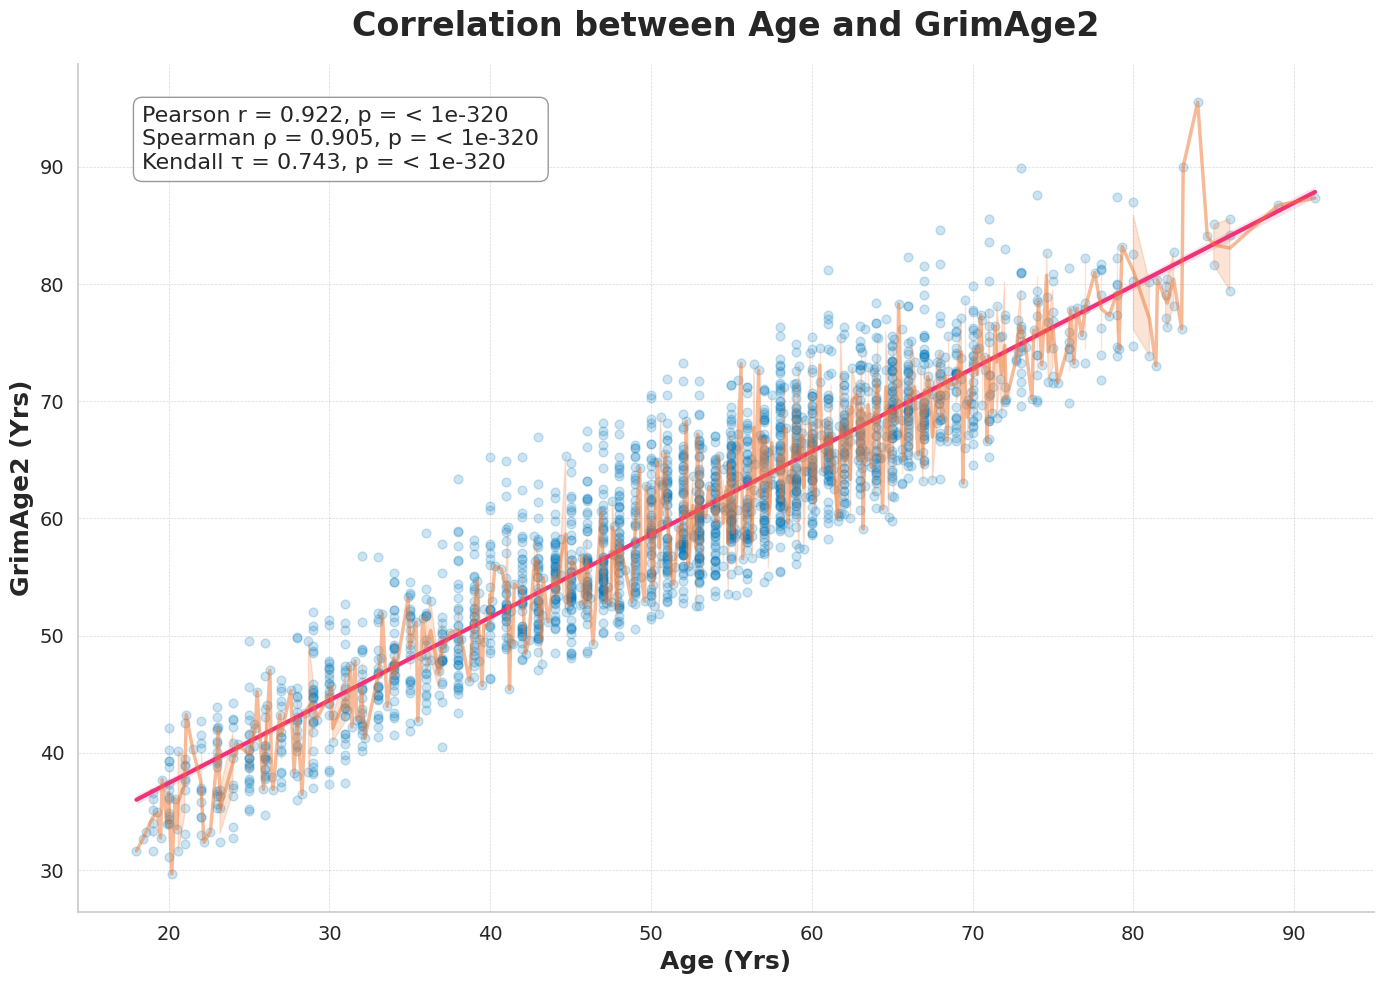

In [61]:
# Set the theme and style for the plot
sns.set_theme(style="whitegrid")

# Create the figure and axis objects
plt.figure(figsize=(14, 10))

# Define a modern color palette with strong contrast and color-blind safety
colors = ['#0077BB', '#EE3377', '#EE7733']  # Vivid Blue, Vibrant Pink, Bright Orange

# Use seaborn's regplot for scatter plot with regression line
sns.regplot(
    x=age_clean,
    y=grimage2_clean,
    ci=95,
    scatter_kws={"s": 40, "alpha": 0.2, "color": colors[0]},  # Vivid Blue points with adjusted opacity
    line_kws={"color": colors[1], "linewidth": 3, "alpha": 1},  # Vibrant Pink regression line, thicker and more opaque
)

# Add a line plot with confidence interval
sns.lineplot(
    x=age_clean,
    y=grimage2_clean,
    errorbar=('ci', 99),
    lw=2.5,  # Increase line width for better visibility
    color=colors[2],  # Bright Orange line plot
    alpha=0.5,  # Increase opacity for confidence intervals
)

# Add titles and labels with enhanced font size
plt.title('Correlation between Age and GrimAge2', fontsize=24, weight='bold', pad=20)
plt.xlabel('Age (Yrs)', fontsize=18, weight='bold')
plt.ylabel('GrimAge2 (Yrs)', fontsize=18, weight='bold')

# Define a threshold for extremely small p-values
threshold = 1e-320

# Create a legend with correlation statistics
legend_text = (
    f"Pearson r = {pearson_corr:.3f}, p = {'< {:.0e}'.format(threshold) if pearson_p_value < threshold else '{:.3e}'.format(pearson_p_value)}\n"
    f"Spearman ρ = {spearman_corr:.3f}, p = {'< {:.0e}'.format(threshold) if spearman_p_value < threshold else '{:.3e}'.format(spearman_p_value)}\n"
    f"Kendall τ = {kendall_corr:.3f}, p = {'< {:.0e}'.format(threshold) if kendall_p_value < threshold else '{:.3e}'.format(kendall_p_value)}"
)
plt.text(0.05, 0.95, legend_text, ha='left', va='top', transform=plt.gca().transAxes, fontsize=16,
         bbox=dict(boxstyle="round,pad=0.4", edgecolor="gray", facecolor="white", alpha=0.8))

# Customize the ticks and labels for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid lines
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

# Remove the top and right spines for a cleaner look
sns.despine()

# Adjust the plot margins
plt.tight_layout()

# Save the plot as an SVG file for high resolution
plt.savefig('Age_vs_GrimAge2_Correlation_Accessible.svg', format='svg', dpi=4000, bbox_inches='tight')

# Show the plot
plt.show()

In [73]:
# Extract relevant data and regroup diagnoses
df = result_adata.obs.copy()
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 'Bipolar' if 'Bipolar' in x else 'Other')
# Print diagnosis counts
diagnosis_counts = df['Diagnosis'].value_counts()
print("Diagnosis Counts:")
print(diagnosis_counts)

# Create a DataFrame with all necessary information
data = pd.DataFrame({
    'Age': df['Age'],
    'GrimAge2': df['grimage2'],
    'AgeAccelGrim2': df['AgeAccelGrim2'],
    'Diagnosis': df['Diagnosis']
})

Diagnosis Counts:
Diagnosis
Bipolar    1530
Other       912
Name: count, dtype: int64


In [100]:
# Assuming the DataFrame df is already created as shown in the previous snippets
# Recalculate the Diagnosis grouping
df['Diagnosis'] = df['Diagnosis'].apply(lambda x: 'Bipolar' if 'Bipolar' in x else 'Other')

# Generate the demographic summary
demographics_summary = pd.DataFrame({
    'Characteristic': ['Age', 'Female', 'Male'],
    'Bipolar (n={})'.format((df['Diagnosis'] == 'Bipolar').sum()): [
        '{} (SD: {:.2f})'.format(df[df['Diagnosis'] == 'Bipolar']['Age'].mean(), df[df['Diagnosis'] == 'Bipolar']['Age'].std()),
        '{} ({:.1f}%)'.format((df[(df['Diagnosis'] == 'Bipolar') & (df['Female'] == 1)].shape[0]), 
                               (df[(df['Diagnosis'] == 'Bipolar') & (df['Female'] == 1)].shape[0]) / df[df['Diagnosis'] == 'Bipolar'].shape[0] * 100),
        '{} ({:.1f}%)'.format((df[(df['Diagnosis'] == 'Bipolar') & (df['Female'] == 0)].shape[0]), 
                               (df[(df['Diagnosis'] == 'Bipolar') & (df['Female'] == 0)].shape[0]) / df[df['Diagnosis'] == 'Bipolar'].shape[0] * 100)
    ],
    'Other (n={})'.format((df['Diagnosis'] == 'Other').sum()): [
        '{} (SD: {:.2f})'.format(df[df['Diagnosis'] == 'Other']['Age'].mean(), df[df['Diagnosis'] == 'Other']['Age'].std()),
        '{} ({:.1f}%)'.format((df[(df['Diagnosis'] == 'Other') & (df['Female'] == 1)].shape[0]), 
                               (df[(df['Diagnosis'] == 'Other') & (df['Female'] == 1)].shape[0]) / df[df['Diagnosis'] == 'Other'].shape[0] * 100),
        '{} ({:.1f}%)'.format((df[(df['Diagnosis'] == 'Other') & (df['Female'] == 0)].shape[0]), 
                               (df[(df['Diagnosis'] == 'Other') & (df['Female'] == 0)].shape[0]) / df[df['Diagnosis'] == 'Other'].shape[0] * 100)
    ]
})

# Export to CSV
demographics_summary.to_csv('demographics_summary.csv', index=False)
demographics_summary

,Characteristic,Bipolar (n=1530),Other (n=912)
0,Age,50.191568627450984 (SD: 12.39),53.450986842105266 (SD: 15.53)
1,Female,875 (57.2%),530 (58.1%)
2,Male,655 (42.8%),382 (41.9%)


In [103]:
# Assuming df is already defined as you have in your snippet
# Group by Diagnosis and calculate selected relevant statistics, including percentiles
summary_table = data.groupby('Diagnosis').agg({
    'Age': ['count', 'mean', 'std', lambda x: x.median()],
    'GrimAge2': ['mean', 'std', lambda x: x.median()],
    'AgeAccelGrim2': ['mean', 'std', lambda x: x.median()]
})

# Rename the columns to shorter and more intuitive names
summary_table.columns = [
    'Count', 'Age_Mean', 'Age_SD', 'Age_Median',
    'GrimAge2_Mean', 'GrimAge2_SD', 'GrimAge2_Median',
    'AgeAccelGrim2_Mean', 'AgeAccelGrim2_SD', 'AgeAccelGrim2_Median'
]

# Reset index to make 'Diagnosis' a column
summary_table = summary_table.reset_index()

# Display the compact summary table
summary_table

,Diagnosis,Count,Age_Mean,Age_SD,Age_Median,GrimAge2_Mean,GrimAge2_SD,GrimAge2_Median,AgeAccelGrim2_Mean,AgeAccelGrim2_SD,AgeAccelGrim2_Median
0,Bipolar,1530,50.191569,12.389986,51.0,59.433587,9.661698,59.791795,0.656173,4.093261,0.272248
1,Other,912,53.450987,15.532425,56.0,59.982916,11.880574,61.554658,-1.100816,3.850500,-1.610269


In [88]:
# Calculate relevant statistics
bipolar_data = data[data['Diagnosis'] == 'Bipolar']['AgeAccelGrim2']
other_data = data[data['Diagnosis'] == 'Other']['AgeAccelGrim2']
t_stat, p_value = stats.ttest_ind(bipolar_data, other_data)
cohens_d = (np.mean(bipolar_data) - np.mean(other_data)) / np.sqrt((np.std(bipolar_data, ddof=1) ** 2 + np.std(other_data, ddof=1) ** 2) / 2)

# Define a threshold for extremely small p-values
threshold = 1e-320

# Function to add stats to the plot
def add_stats_to_plot(ax):
    # Format the p-value
    p_value_str = '< {:.0e}'.format(threshold) if p_value < threshold else f"{p_value:.4e}"
    
    # Create the stats text
    stats_text = (f"T-test p-value: {p_value_str}\n"
                  f"Cohen's d: {cohens_d:.4f}\n"
                  f"n(Bipolar): {len(bipolar_data)}\n"
                  f"n(Other): {len(other_data)}")
    
     # Add the stats text to the plot in a different location
    ax.text(0.95, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


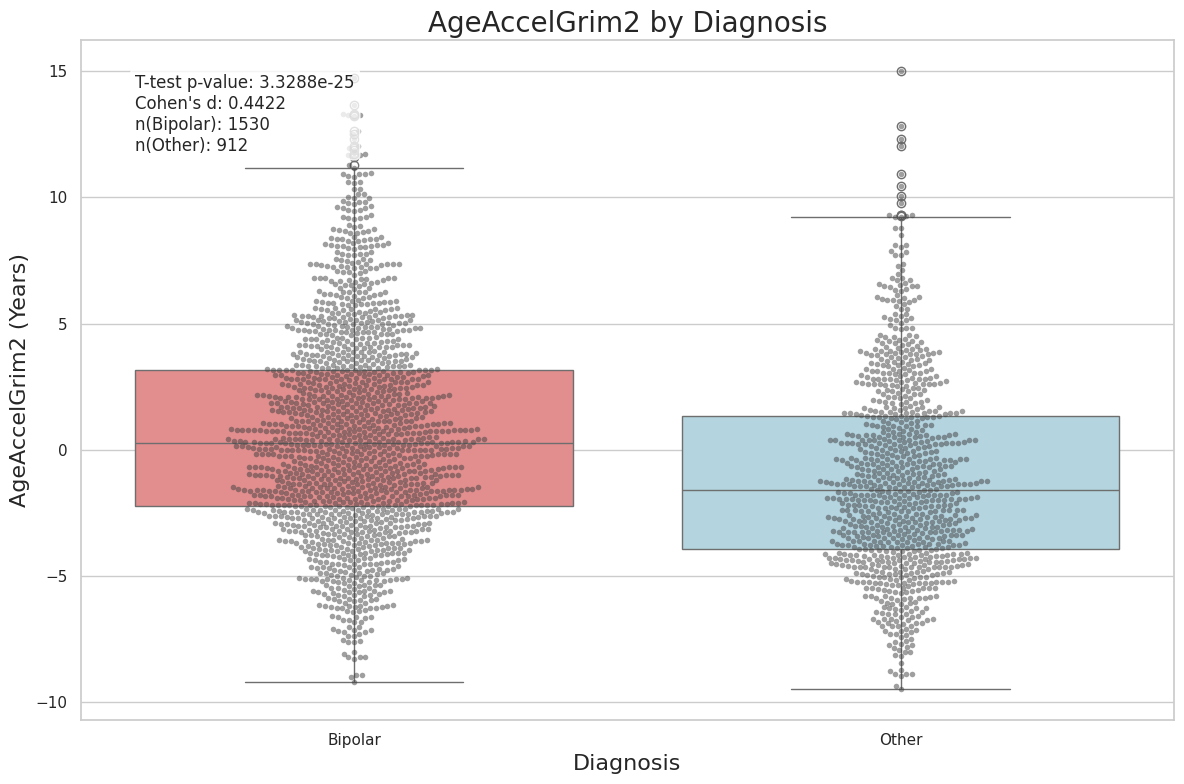

In [81]:
# Set the style for all plots
sns.set_style("whitegrid")  # Or choose another style like "darkgrid", "white", "dark", etc.
sns.set_palette("Set2")

# 1. Box plot of AgeAccelGrim2 by Diagnosis
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Diagnosis', y='AgeAccelGrim2', data=data, palette={'Bipolar': 'lightcoral', 'Other': 'lightblue'})
sns.swarmplot(x='Diagnosis', y='AgeAccelGrim2', data=data, color=".25", size=4, alpha=0.5)
plt.title('AgeAccelGrim2 by Diagnosis', fontsize=20)
plt.xlabel('Diagnosis', fontsize=16)
plt.ylabel('AgeAccelGrim2 (Years)', fontsize=16)
add_stats_to_plot(ax)
plt.tight_layout()
plt.savefig('ageaccelgrim2_by_diagnosis_boxplot.png', dpi=300)
plt.show()

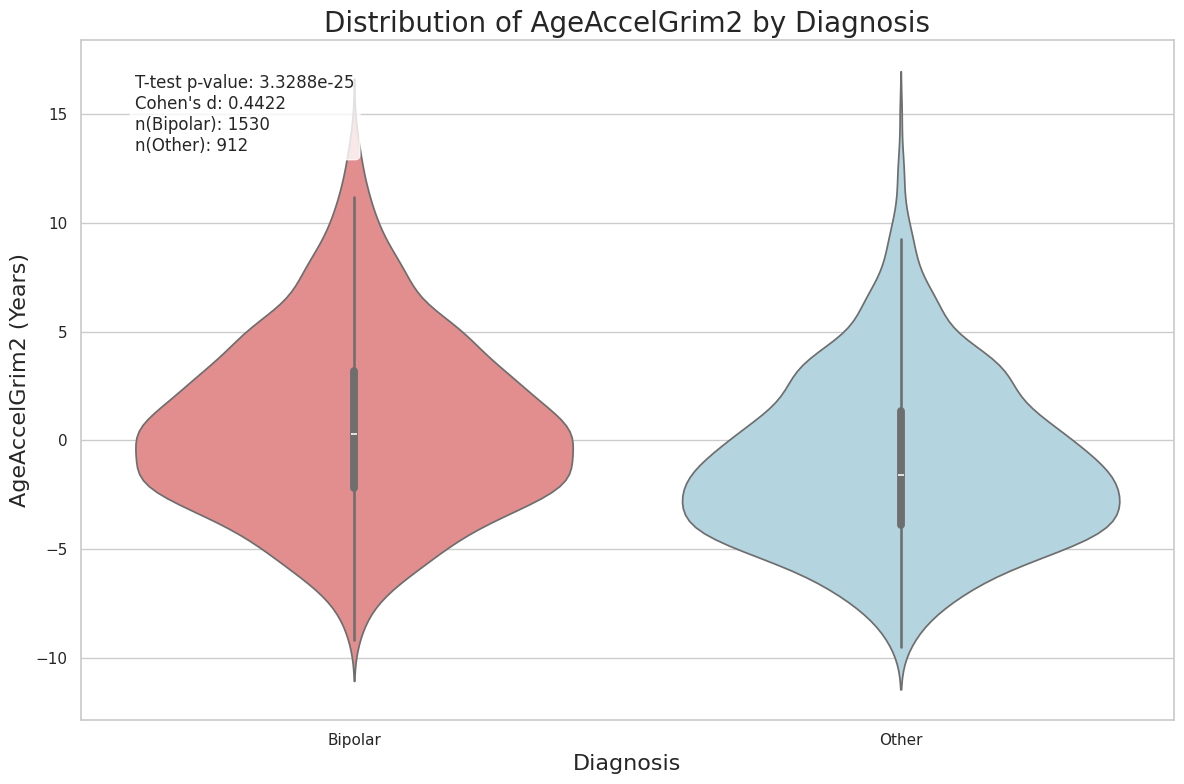

In [82]:
# 2. Violin plot of AgeAccelGrim2 by Diagnosis
plt.figure(figsize=(12, 8))
ax = sns.violinplot(x='Diagnosis', y='AgeAccelGrim2', data=data, palette={'Bipolar': 'lightcoral', 'Other': 'lightblue'})
plt.title('Distribution of AgeAccelGrim2 by Diagnosis', fontsize=20)
plt.xlabel('Diagnosis', fontsize=16)
plt.ylabel('AgeAccelGrim2 (Years)', fontsize=16)
add_stats_to_plot(ax)
plt.tight_layout()
plt.savefig('ageaccelgrim2_by_diagnosis_violin.png', dpi=300)
plt.show()

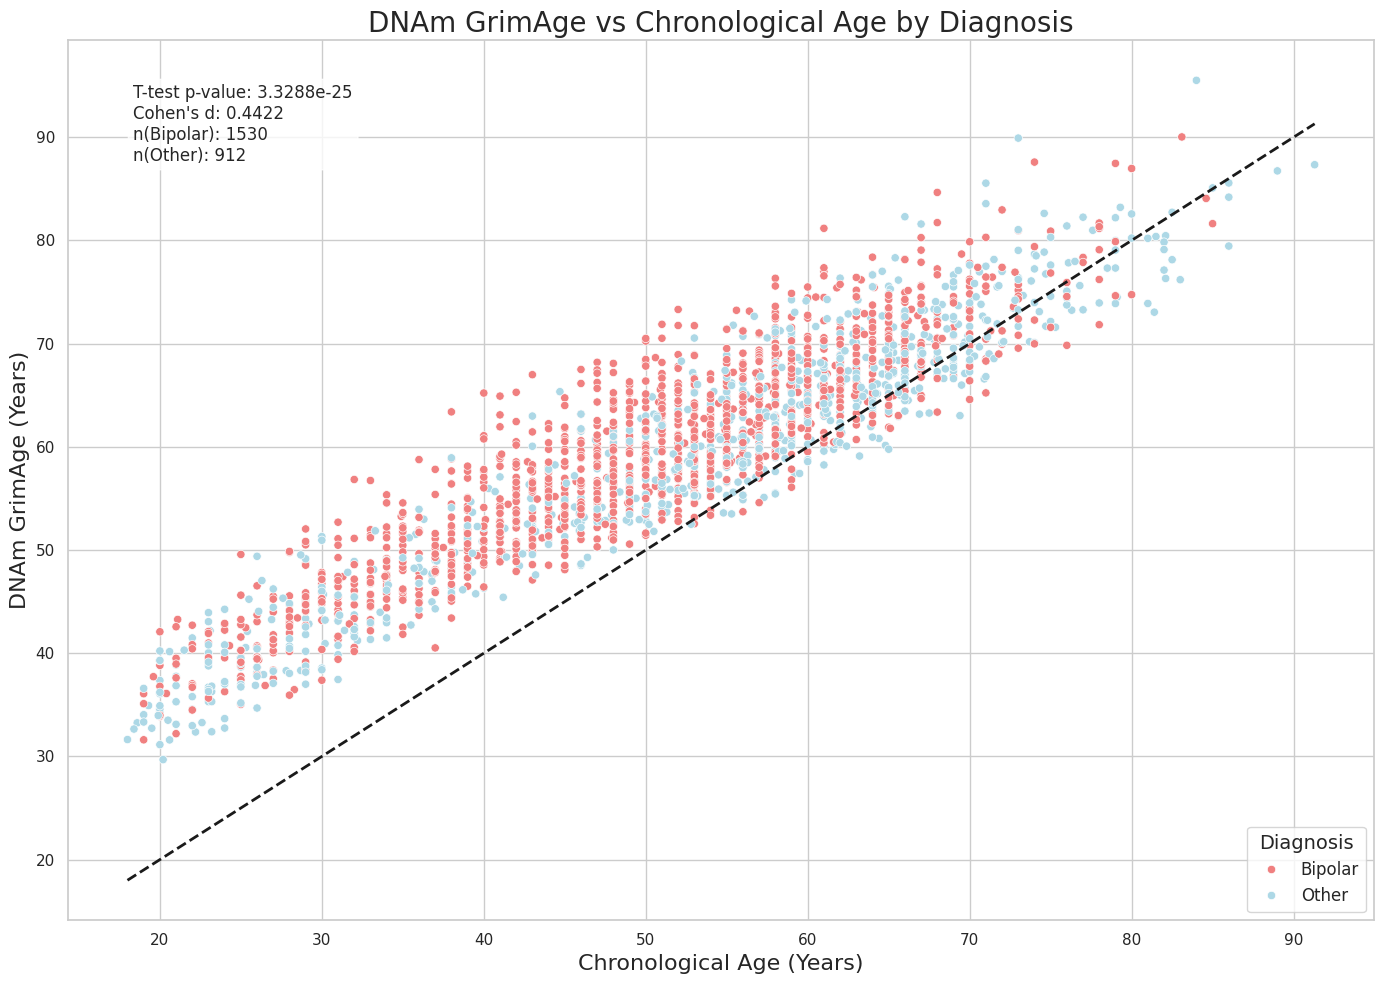

In [83]:
# 3. Scatter plot of GrimAge2 vs Chronological Age, colored by Diagnosis
plt.figure(figsize=(14, 10))
ax = sns.scatterplot(x='Age', y='GrimAge2', hue='Diagnosis', data=data, palette={'Bipolar': 'lightcoral', 'Other': 'lightblue'})
plt.plot([data['Age'].min(), data['Age'].max()], [data['Age'].min(), data['Age'].max()], 'k--', lw=2)
plt.title('DNAm GrimAge vs Chronological Age by Diagnosis', fontsize=20)
plt.xlabel('Chronological Age (Years)', fontsize=16)
plt.ylabel('DNAm GrimAge (Years)', fontsize=16)
plt.legend(title='Diagnosis', title_fontsize='14', fontsize='12')
add_stats_to_plot(ax)
plt.tight_layout()
plt.savefig('grimage2_vs_age_by_diagnosis_scatter.png', dpi=300)
plt.show()

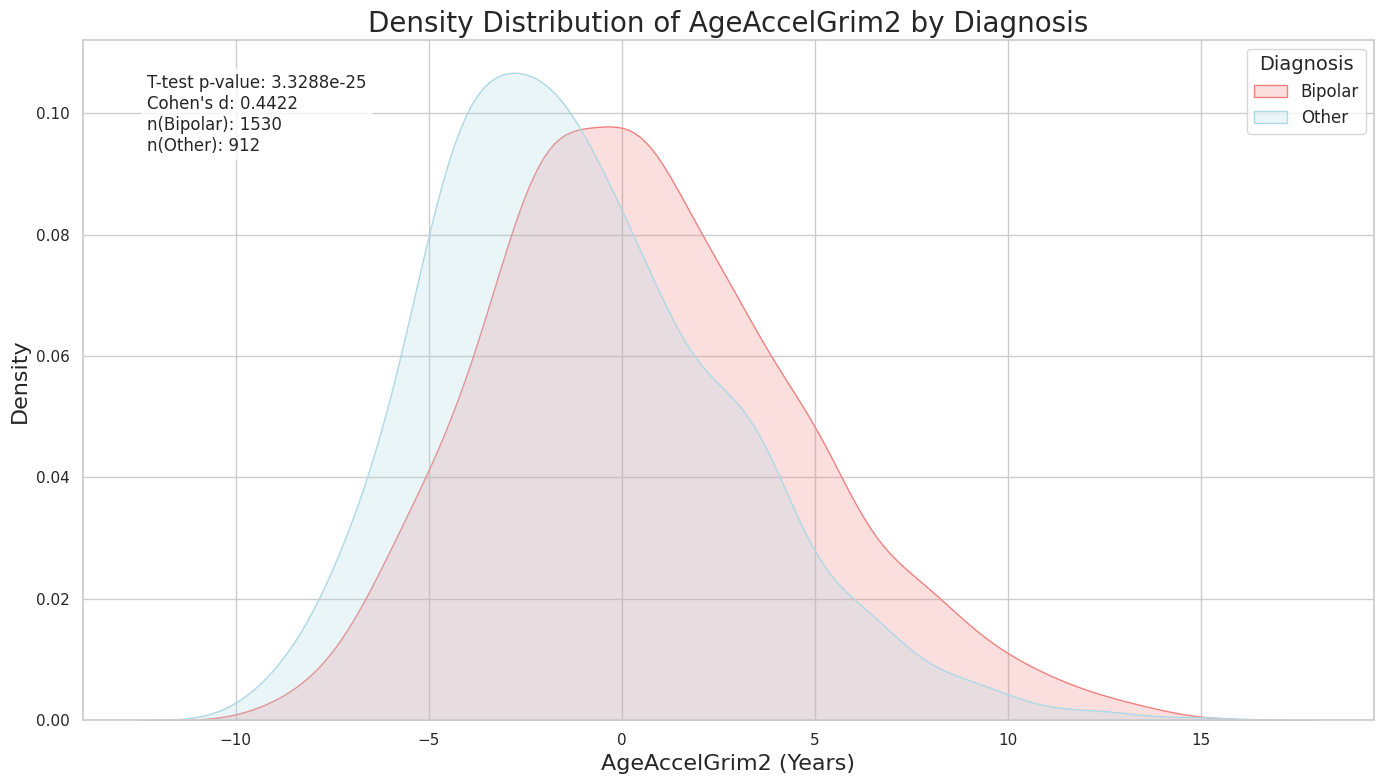

In [84]:
# 4. Density plot of AgeAccelGrim2 by Diagnosis
plt.figure(figsize=(14, 8))
ax = sns.kdeplot(data=data[data['Diagnosis'] == 'Bipolar']['AgeAccelGrim2'], shade=True, label='Bipolar', color='lightcoral')
sns.kdeplot(data=data[data['Diagnosis'] == 'Other']['AgeAccelGrim2'], shade=True, label='Other', color='lightblue')
plt.title('Density Distribution of AgeAccelGrim2 by Diagnosis', fontsize=20)
plt.xlabel('AgeAccelGrim2 (Years)', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(title='Diagnosis', title_fontsize='14', fontsize='12')
add_stats_to_plot(ax)
plt.tight_layout()
plt.savefig('ageaccelgrim2_by_diagnosis_density.png', dpi=300)
plt.show()

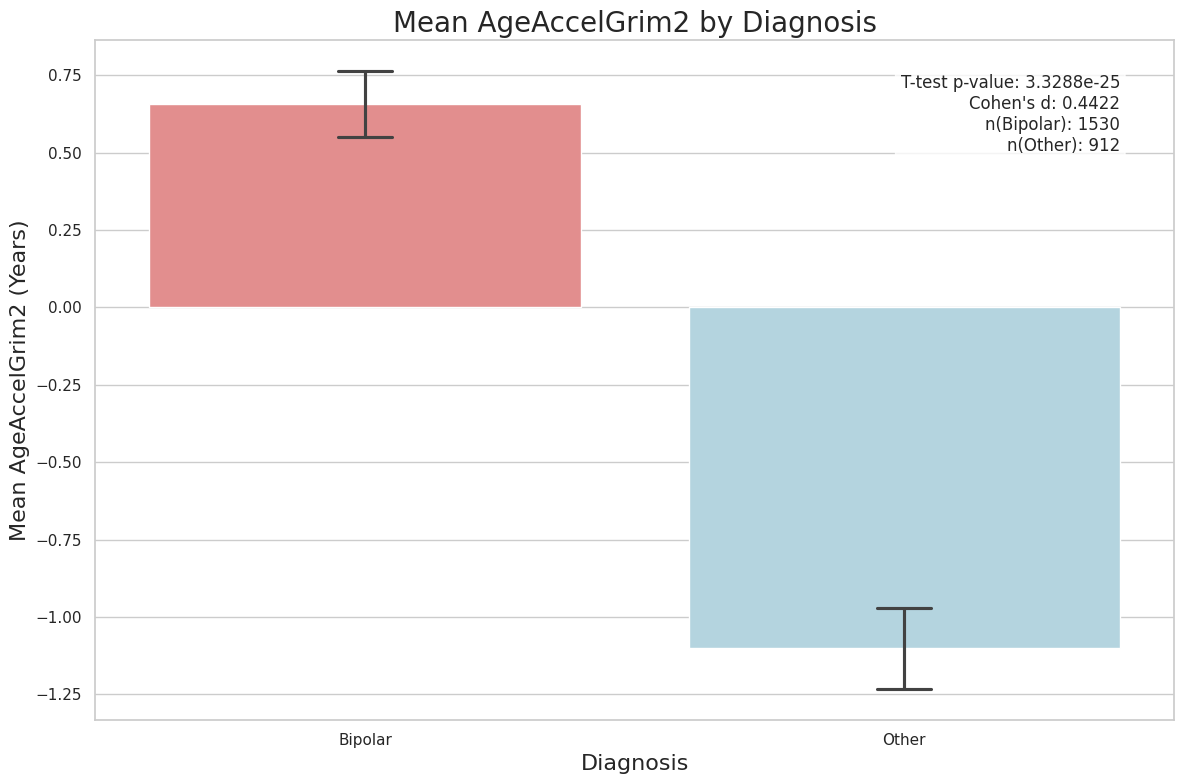

In [89]:
# 5. Bar plot of mean AgeAccelGrim2 by Diagnosis with error bars
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Diagnosis', y='AgeAccelGrim2', data=data, ci=68, capsize=0.1, palette={'Bipolar': 'lightcoral', 'Other': 'lightblue'})
plt.title('Mean AgeAccelGrim2 by Diagnosis', fontsize=20)
plt.xlabel('Diagnosis', fontsize=16)
plt.ylabel('Mean AgeAccelGrim2 (Years)', fontsize=16)
add_stats_to_plot(ax)
plt.tight_layout()
plt.savefig('mean_ageaccelgrim2_by_diagnosis_barplot.png', dpi=300)
plt.show()

In [86]:
# 6. Statistical tests
# T-test
t_stat, p_value = stats.ttest_ind(data[data['Diagnosis'] == 'Bipolar']['AgeAccelGrim2'],
                                  data[data['Diagnosis'] == 'Other']['AgeAccelGrim2'])
print(f"\nIndependent t-test results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Effect size (Cohen's d)
bipolar_data = data[data['Diagnosis'] == 'Bipolar']['AgeAccelGrim2']
other_data = data[data['Diagnosis'] == 'Other']['AgeAccelGrim2']
cohens_d = (np.mean(bipolar_data) - np.mean(other_data)) / np.sqrt((np.std(bipolar_data, ddof=1) ** 2 + np.std(other_data, ddof=1) ** 2) / 2)
print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")

# 6. ANCOVA (controlling for age)
model = ols('AgeAccelGrim2 ~ C(Diagnosis) + Age', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANCOVA Results (controlling for age):")
print(anova_table)


Independent t-test results:
T-statistic: 10.4884
P-value: 0.0000

Effect size (Cohen's d): 0.4422

ANCOVA Results (controlling for age):
                    sum_sq      df           F        PR(>F)
C(Diagnosis)   1787.477332     1.0  111.496427  1.622214e-25
Age              23.559258     1.0    1.469542  2.255354e-01
Residual      39101.317832  2439.0         NaN           NaN


In [56]:
# Initialize logger and load clock metadata
logger = pya.logger.LoggerManager.gen_logger("example")
metadata = pya.utils._utils.load_clock_metadata("pyaging_data", logger)

# Filter for methylation clocks only
methylation_clocks = {k: v for k, v in metadata.items() if v.get('data_type') == 'methylation'}
filtered_clocks = list(methylation_clocks.keys())

# Print all available clocks and filtered methylation clocks
print("All available clocks:", list(metadata.keys()))
print("Methylation clocks:", filtered_clocks)

|-----> ⚙️ Load all clock metadata started
|-----------------> Data found in pyaging_data/all_clock_metadata.pt
|-----> ✅ Load all clock metadata finished [0.0030s]
All available clocks: ['epitoc1', 'zhangmortality', 'horvath2013', 'stoch', 'encen100', 'camilloh3k36me3', 'stocp', 'knight', 'meer', 'stubbs', 'ocampoatac2', 'lin', 'leerobust', 'camilloh3k9ac', 'mammalian1', 'pchorvath2013', 'dnamfitage', 'replitali', 'thompson', 'stemtoc', 'yingcausage', 'yingadaptage', 'camillopanhistone', 'petkovich', 'stocz', 'mammalianskin3', 'han', 'grimage2', 'pcphenoage', 'camilloh3k4me3', 'skinandblood', 'retroelementagev1', 'yingdamage', 'mammalianskin2', 'mammalianblood2', 'retroelementagev2', 'zhangblup', 'pcgrimage', 'dnamphenoage', 'pchannum', 'mammalianlifespan', 'leecontrol', 'intrinclock', 'pcdnamtl', 'leerefinedrobust', 'pedbe', 'mammalianblood3', 'camilloh3k4me1', 'camilloh3k27ac', 'mammalianfemale', 'grimage', 'dunedinpace', 'bitage', 'dnamtl', 'camilloh3k9me3', 'ocampoatac1', 'camillo

In [58]:
for clock in filtered_clocks:
    print(f"Clock: {clock}, Data Type: {methylation_clocks[clock]['data_type']}")

Clock: epitoc1, Data Type: methylation
Clock: zhangmortality, Data Type: methylation
Clock: horvath2013, Data Type: methylation
Clock: stoch, Data Type: methylation
Clock: encen100, Data Type: methylation
Clock: stocp, Data Type: methylation
Clock: knight, Data Type: methylation
Clock: meer, Data Type: methylation
Clock: stubbs, Data Type: methylation
Clock: lin, Data Type: methylation
Clock: leerobust, Data Type: methylation
Clock: mammalian1, Data Type: methylation
Clock: pchorvath2013, Data Type: methylation
Clock: dnamfitage, Data Type: methylation
Clock: replitali, Data Type: methylation
Clock: thompson, Data Type: methylation
Clock: stemtoc, Data Type: methylation
Clock: yingcausage, Data Type: methylation
Clock: yingadaptage, Data Type: methylation
Clock: petkovich, Data Type: methylation
Clock: stocz, Data Type: methylation
Clock: mammalianskin3, Data Type: methylation
Clock: han, Data Type: methylation
Clock: grimage2, Data Type: methylation
Clock: pcphenoage, Data Type: methy

In [ ]:
# List of all clocks to process
clocks_to_process = all_clocks

In [ ]:
# Predict age using GrimAge2
# Iterate over each clock and attempt to predict age
for clock in all_clocks:
    try:
        print(f"Processing clock: {clock}")
        pya.pred.predict_age(adata_final, clock_names=[clock], dir="pyaging_data", batch_size=1024, clean=True, verbose=True)
        print(f"Successfully processed clock: {clock}")
    except Exception as e:
        print(f"Failed to process clock: {clock} due to error: {e}")
#pya.pred.predict_age(adata_subset)

In [ ]:
def predict_clock_components(adata, clock_name, dir="pyaging_data", batch_size=1024):
    """
    Wrapper function to predict clock age and attempt to extract additional components.
    Returns a new AnnData object with original data and clock results.
    """
    if not isinstance(adata, ad.AnnData):
        raise TypeError("Input must be an AnnData object")

    # Create a copy of the original adata object
    adata_copy = adata.copy()

    # Run the original predict_age function
    pya.pred.predict_age(adata_copy, clock_names=[clock_name], dir=dir, batch_size=batch_size)
    
    if clock_name not in adata_copy.obs:
        raise KeyError(f"'{clock_name}' not found in adata_copy.obs. Make sure predict_age() ran successfully.")
    
    # Load the clock model
    model = pya.predict._pred_utils.load_clock(clock_name, "cuda" if torch.cuda.is_available() else "cpu", dir, pya.logger.Logger())
    
    # Get the input data
    X = adata_copy.obsm[f"X_{clock_name}"] if f"X_{clock_name}" in adata_copy.obsm else adata_copy.X
    
    # Attempt to predict components
    try:
        components = predict_components(model, X, batch_size)
        
        # Add component predictions to adata_copy.obs
        for component, values in components.items():
            adata_copy.obs[f"{clock_name}_{component}"] = values
        
        # Special handling for GrimAge2
        if clock_name == 'grimage2':
            adata_copy.obs['AgeAccelGrim2'] = calculate_age_accel_grim2(adata_copy.obs['Age'], adata_copy.obs['grimage2'])
            
            # Rename components to match R code for GrimAge2
            rename_dict = {
                'grimage2_ADM': 'DNAmADM',
                'grimage2_CystatinC': 'DNAmCystatinC',
                'grimage2_GDF15': 'DNAmGDF15',
                'grimage2_Leptin': 'DNAmLeptin',
                'grimage2_PAI1': 'DNAmPAI1',
                'grimage2_TIMP1': 'DNAmTIMP1',
                'grimage2_LogCRP': 'DNAmlogCRP',
                'grimage2_A1C': 'DNAmlogA1C',
                'grimage2_PACKYRS': 'DNAmPACKYRS',
                'grimage2_B2M': 'DNAmB2M'
            }
            adata_copy.obs.rename(columns=rename_dict, inplace=True)

    except AttributeError:
        print(f"No additional components found for {clock_name}")
    
    return adata_copy

def predict_components(model, X, batch_size=1024):
    """
    Helper function to predict clock components.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Ensure X is a numpy array
    if isinstance(X, ad.AnnData):
        X = X.X
    if scipy.sparse.issparse(X):
        X = X.toarray()
    
    # Convert to torch tensor and ensure it's float32
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    
    dataset = torch.utils.data.TensorDataset(X_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    components = {}
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0]
            
            # Attempt to predict individual components
            for name, module in model.named_children():
                if isinstance(module, torch.nn.Linear) and name != 'base_model':
                    features = getattr(model, f'features_{name}', None)
                    if features is not None:
                        module.to(torch.float32)
                        component_pred = module(batch[:, features])
                        if name not in components:
                            components[name] = []
                        components[name].append(component_pred.cpu().numpy())
    
    # Concatenate results
    for component in components.keys():
        components[component] = np.concatenate(components[component])
    
    return components

def calculate_age_accel_grim2(age, grimage2):
    """
    Calculate AgeAccelGrim2 using the residuals method.
    """
    slope, intercept, r_value, p_value, std_err = stats.linregress(age, grimage2)
    predicted = slope * age + intercept
    age_accel_grim2 = grimage2 - predicted
    return age_accel_grim2

# Function to process all clocks
def process_all_clocks(adata, all_clocks, dir="pyaging_data", batch_size=1024):
    results = {}
    for clock in all_clocks:
        try:
            print(f"Processing clock: {clock}")
            result_adata = predict_clock_components(adata, clock, dir=dir, batch_size=batch_size)
            results[clock] = result_adata
            print(f"Successfully processed clock: {clock}")
        except Exception as e:
            print(f"Failed to process clock: {clock} due to error: {e}")
    return results

In [ ]:
# Usage
results = process_all_clocks(adata_final, all_clocks)

In [ ]:
# Print results
for clock, result_adata in results.items():
    print(f"\nResults for {clock}:")
    clock_columns = [col for col in result_adata.obs.columns if col.startswith(clock) or col in ['Age', 'AgeAccelGrim2']]
    print("Clock-specific columns:", clock_columns)
    print(result_adata.obs[clock_columns].head())

In [ ]:
model = pya.models.GrimAge2()

In [ ]:
model.metadata.update({
    "clock_name": 'grimage2',
    "data_type": 'methylation',
    "species": 'Homo sapiens',
    "year": 2022,
    "approved_by_author": '⌛',
    "citation": "Lu, Ake T., et al. \"DNA methylation GrimAge version 2.\" Aging (Albany NY) 14.23 (2022): 9484.",
    "doi": "https://doi.org/10.18632/aging.204434",
    "research_only": True,
    "notes": None
})

In [ ]:
urls = [
    "https://pyaging.s3.amazonaws.com/supporting_files/grimage2_subcomponents.csv",
    "https://pyaging.s3.amazonaws.com/supporting_files/grimage2.csv",
    "https://pyaging.s3.amazonaws.com/supporting_files/datMiniAnnotation3_Gold.csv",
]
dir = "."
logger = pya.logger.Logger()

for url in urls:
    pya.utils.download(url, dir, logger, indent_level=1)

In [ ]:
# Load feature sets from CSV files
df = pd.read_csv('grimage2_subcomponents.csv', index_col=0)
df_grimage = pd.read_csv('grimage2.csv', index_col=0)

# Identify features
all_features = np.unique(df['var'])[2:].tolist() + ['Female', 'Age']
model.features = all_features

In [ ]:
# Function to load weights for subcomponents
def load_model_weights(y_pred, model_attr):
    indices = torch.tensor([all_features.index(item) for item in df.loc[df['Y.pred'] == y_pred, 'var'] if item in all_features]).long()
    model_layer = pya.models.LinearModel(input_dim=len(indices))
    model_layer.linear.weight.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'][1:].values).unsqueeze(0).float()
    model_layer.linear.bias.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'].iloc[0]).float()
    setattr(model, model_attr, model_layer)
    setattr(model, f'features_{model_attr}', indices)

# Apply the function to each subcomponent
components = {
    'DNAmPACKYRS': 'PACKYRS', 
    'DNAmadm': 'ADM', 
    'DNAmB2M': 'B2M',
    'DNAmCystatin_C': 'CystatinC', 
    'DNAmGDF_15': 'GDF15',
    'DNAmleptin': 'Leptin',
    'DNAmpai_1': 'PAI1',
    'DNAmTIMP_1': 'TIMP1',
    'DNAmlog.CRP': 'LogCRP',
    'DNAmlog.A1C': 'A1C'
}

for y_pred, model_attr in components.items():
    load_model_weights(y_pred, model_attr)

# Load base model weights
base_model = pya.models.LinearModel(input_dim=len(df_grimage))
base_model.linear.weight.data = torch.tensor(df_grimage['beta'].tolist()).unsqueeze(0).float()
base_model.linear.bias.data = torch.tensor([0]).float()
model.base_model = base_model

In [ ]:
reference_df = pd.read_csv('datMiniAnnotation3_Gold.csv', index_col=0)
model.reference_values = reference_df.loc[model.features[:-2]]['gold'].tolist() + [1, 65]  # Example: 65-year-old female

In [ ]:
# Define the directory path
weights_dir = "../weights"

# Create the directory if it doesn't exist
os.makedirs(weights_dir, exist_ok=True)

# Save the model
torch.save(model, os.path.join(weights_dir, f"{model.metadata['clock_name']}.pt"))

In [ ]:
# Load the Feather file
methylation_data_final_pd_prepared = fth.read_feather('/u/scratch/c/cobeaman/methylation_data_final_pd_prepared.feather')

In [ ]:
# print(methylation_data_subset_pd.columns)
missing_features = [feature for feature in model.features if feature not in methylation_data_final_pd_prepared.columns]
# print("Missing features:", missing_features)
missing_features

In [ ]:
# Ensure the feature indices are within the bounds of available data
for y_pred, model_attr in components.items():
    valid_indices = [all_features.index(item) for item in df.loc[df['Y.pred'] == y_pred, 'var'] if item in available_features]
    indices = torch.tensor(valid_indices).long()
    model_layer = pya.models.LinearModel(input_dim=len(indices))
    model_layer.linear.weight.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'][1:].values).unsqueeze(0).float()
    model_layer.linear.bias.data = torch.tensor(df.loc[df['Y.pred'] == y_pred, 'beta'].iloc[0]).float()
    setattr(model, model_attr, model_layer)
    setattr(model, f'features_{model_attr}', indices)

# After adjusting indices, run the model
input_tensor_final = torch.tensor(input_data_final, dtype=torch.float32)

# Move the model to the appropriate device and data type
model.to(torch.float32)
model.eval()

# Predict
pred = model(input_tensor_final)
print(pred)

In [ ]:
from pyaging.predict._pred_utils import predict_ages_with_model

# Assuming adata_final is your AnnData object and model is already trained
adata_final = ad.read_h5ad('/u/scratch/c/cobeaman/adata_final.h5ad')

In [ ]:
# Define your logger and device
logger = pya.logger.Logger()
device = "cuda"
batch_size = 1024  # Set an appropriate batch size for your data

In [ ]:
# Ensure the model is in evaluation mode
model.eval()
model.to(device)

# Predict ages or biological markers
predictions = predict_ages_with_model(adata_final, model, device, batch_size, logger)

# Convert predictions to numpy and append to adata.obs
adata_final.obs[f"{model.metadata['clock_name']}_predictions"] = predictions.cpu().numpy()

# To view the appended DataFrame
print(adata_final.obs.head())

In [ ]:
# Optionally, save the updated AnnData object
adata_final.write_h5ad('/u/scratch/c/cobeaman/adata_final_with_predictions.h5ad')

In [ ]:
# Extract relevant features
# Adjust the model's features list to include only those present in the data
available_features = [feature for feature in model.features if feature in methylation_data_final_pd_prepared.columns]
input_data_final = methylation_data_final_pd_prepared[available_features].values

# Convert to tensor and run the model
input_tensor_final = torch.tensor(input_data_final, dtype=torch.float32)
model.eval()
model.to(float)
pred = model(input_tensor_final)
print(pred)

In [ ]:
def remove_folder(path):
    try:
        shutil.rmtree(path)
        print(f"Deleted folder: {path}")
    except Exception as e:
        print(f"Error deleting folder {path}: {e}")

# Get a list of all files and folders in the current directory
all_items = os.listdir('.')        

In [ ]:
for item in os.listdir('.'):
    if os.path.isfile(item) and not item.endswith('.ipynb'):
        os.remove(item)
    elif os.path.isdir(item):
        shutil.rmtree(item)